## Regresión con errores correlacionados

Juan Sosa PhD

Email jcsosam@unal.edu.co

GitHub https://github.com/jstats1702

Samuel Sánchez (Python y revisión R)

Email ssanchezgu@unal.edu.co

GitHub https://github.com/Samuel-col

In [1]:
# Librerías base
import numpy as np
import pandas as pd
# Funciones de densidad y muestrear de ellas
import scipy.stats as st
# Función de autocorrelación
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# Modelos lineales generalizados frecuentistas
import statsmodels.api as sm
import statsmodels.formula.api as sm_f
# MCMC
import pyjags as pj
import arviz as av
# Gráficos
# import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


# Modelo

**Verosimilitud**:
$$
\boldsymbol{y}\mid\mathbf{X},\boldsymbol{\beta},\sigma^2,\rho\sim\textsf{N}(\mathbf{X}\boldsymbol{\beta},\sigma^2\mathbf{C}_\rho)
$$
donde $\mathbf{C}_\rho$ es una matriz con estructura autoregresiva de primer orden:
$$
\mathbf{C}_\rho = 
\left[\begin{array}{ccccc}
1 & \rho & \rho^{2} & \cdots & \rho^{n-1} \\
\rho & 1 & \rho & \cdots & \rho^{n-2} \\
\rho^{2} & \rho & 1 & \cdots & \rho^{n-3} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\rho^{n-1} & \rho^{n-2} & \rho^{n-3} & \cdots & 1
\end{array}\right]
$$

Distribución **previa**:
$$
p(\boldsymbol{\beta},\sigma^2,\rho) = p(\boldsymbol{\beta})\,p(\sigma^2)\,p(\rho)
$$
con
$$
\boldsymbol{\beta}\sim\textsf{N}(\boldsymbol{\beta_0},\Sigma_0)\qquad\sigma^2\sim\textsf{GI}\left(\tfrac{\nu_0}{2},\tfrac{\nu_0\,\sigma^2_0}{2}\right)\qquad\rho\sim\textsf{U}(a,b)
$$

Los **parámetros** del modelo son $\boldsymbol{\theta}=(\boldsymbol{\beta},\sigma^2,\rho)$.

Los **hiper-parámetros** del model son $(\boldsymbol{\beta_0},\Sigma_0,\nu_0,\sigma^2_0,a,b)$.



# Estimación

Construir un **muestreador de Gibbs** para obtener muestras de la distribución posterior $p(\boldsymbol{\theta}\mid\boldsymbol{y})$.

- Distribuciones **condicionales completas**:
$$
\begin{aligned}
\boldsymbol{\beta} \mid \operatorname{resto} & \sim \textsf{N}\left(\boldsymbol{\beta}_{n}, \boldsymbol{\Sigma}_{n}\right) \\
\boldsymbol{\Sigma}_{n} &=\left(\boldsymbol{\Sigma}_{0}^{-1}+\frac{1}{\sigma^{2}} \mathbf{X}^{T} \mathbf{C}_{\rho}^{-1} \mathbf{X}\right)^{-1} \\
\boldsymbol{\mu}_{n} &=\boldsymbol{\Sigma}_{n}\left(\boldsymbol{\Sigma}_{0}^{-1} \boldsymbol{\beta}_{0}+\frac{1}{\sigma^{2}} \mathbf{X}^{T} \mathbf{C}_{\rho}^{-1} \boldsymbol{y}\right)
\end{aligned}
$$
$$
\begin{aligned}
\sigma^{2} \mid \text { resto } & \sim \textsf { IG }\left(\frac{\nu_{0}+n}{2}, \frac{\nu_{0} \sigma_{0}^{2}+\mathrm{SSR}_{\rho}}{2}\right) \\
\operatorname{SSR}_{\rho} &=(\boldsymbol{y}-\mathbf{X} \boldsymbol{\beta})^{\textsf{T}} \mathbf{C}_{\rho}^{-1}(\boldsymbol{y}-\mathbf{X} \boldsymbol{\beta})
\end{aligned}
$$

La condicional de $\rho$ no tiene una forma estándar de la cual se pueda simular con facilidad. Por lo tanto, en lugar de muestrar directamente de esta condicional se implementa un paso de Metropolis como sigue:

1. Simular $\rho^*\sim \textsf{U}(\rho\mid\rho^{(b)} - \delta, \rho^{(b)} + \delta)$.
2. Calcular la tasa de aceptación:
$$
r = \frac{p(\rho^*\mid \text{resto})}{p(\rho^{(b)}\mid \text{resto})}\,.
$$
3. Establecer:
$$
\rho^{(b+1)} =
\left\{
  \begin{array}{ll}
    \rho^*\,     , & \hbox{con probabilidad $\min(1,r)$;} \\
    \rho^{(b)}\, , & \hbox{con probabilidad $1-\min(1,r)$.}
  \end{array}
\right.
$$



# Regresión lineal con errores correlacionados

Los análisis de núcleos de hielo de la Antártida han permitido a los 
científicos deducir condiciones atmosféricas históricas de los últimos cientos 
de miles de años. 

***Petit, J. R. et al. (1999). Climate and atmospheric history of the past 420,000 years from the Vostok ice core, Antarctica. Nature, 399(6735), 429-436.***

![](petit2.jpg)

![](petit1.jpg)


Los datos incluyen 200 valores de la temperatura medida en intervalos de tiempo 
aproximadamente iguales; tiempo entre mediciones consecutivas de aproximadamente 
2,000 años. 

La temperatura se registra en términos de su diferencia de la temperatura actual
en grados Celsius, y la concentración de CO2 (dióxido de carbono) se registra 
en partes por millón.

Modelar la temperatura en función del CO2.

**Data**

- $y_i\,\,$: CO2 registrada en el año $i$, para $i=1,\ldots,n$.
- $x_{i}\,$: temperatura registrada en el año $i$.


In [2]:
# data
dct = pd.read_csv("dct.csv")

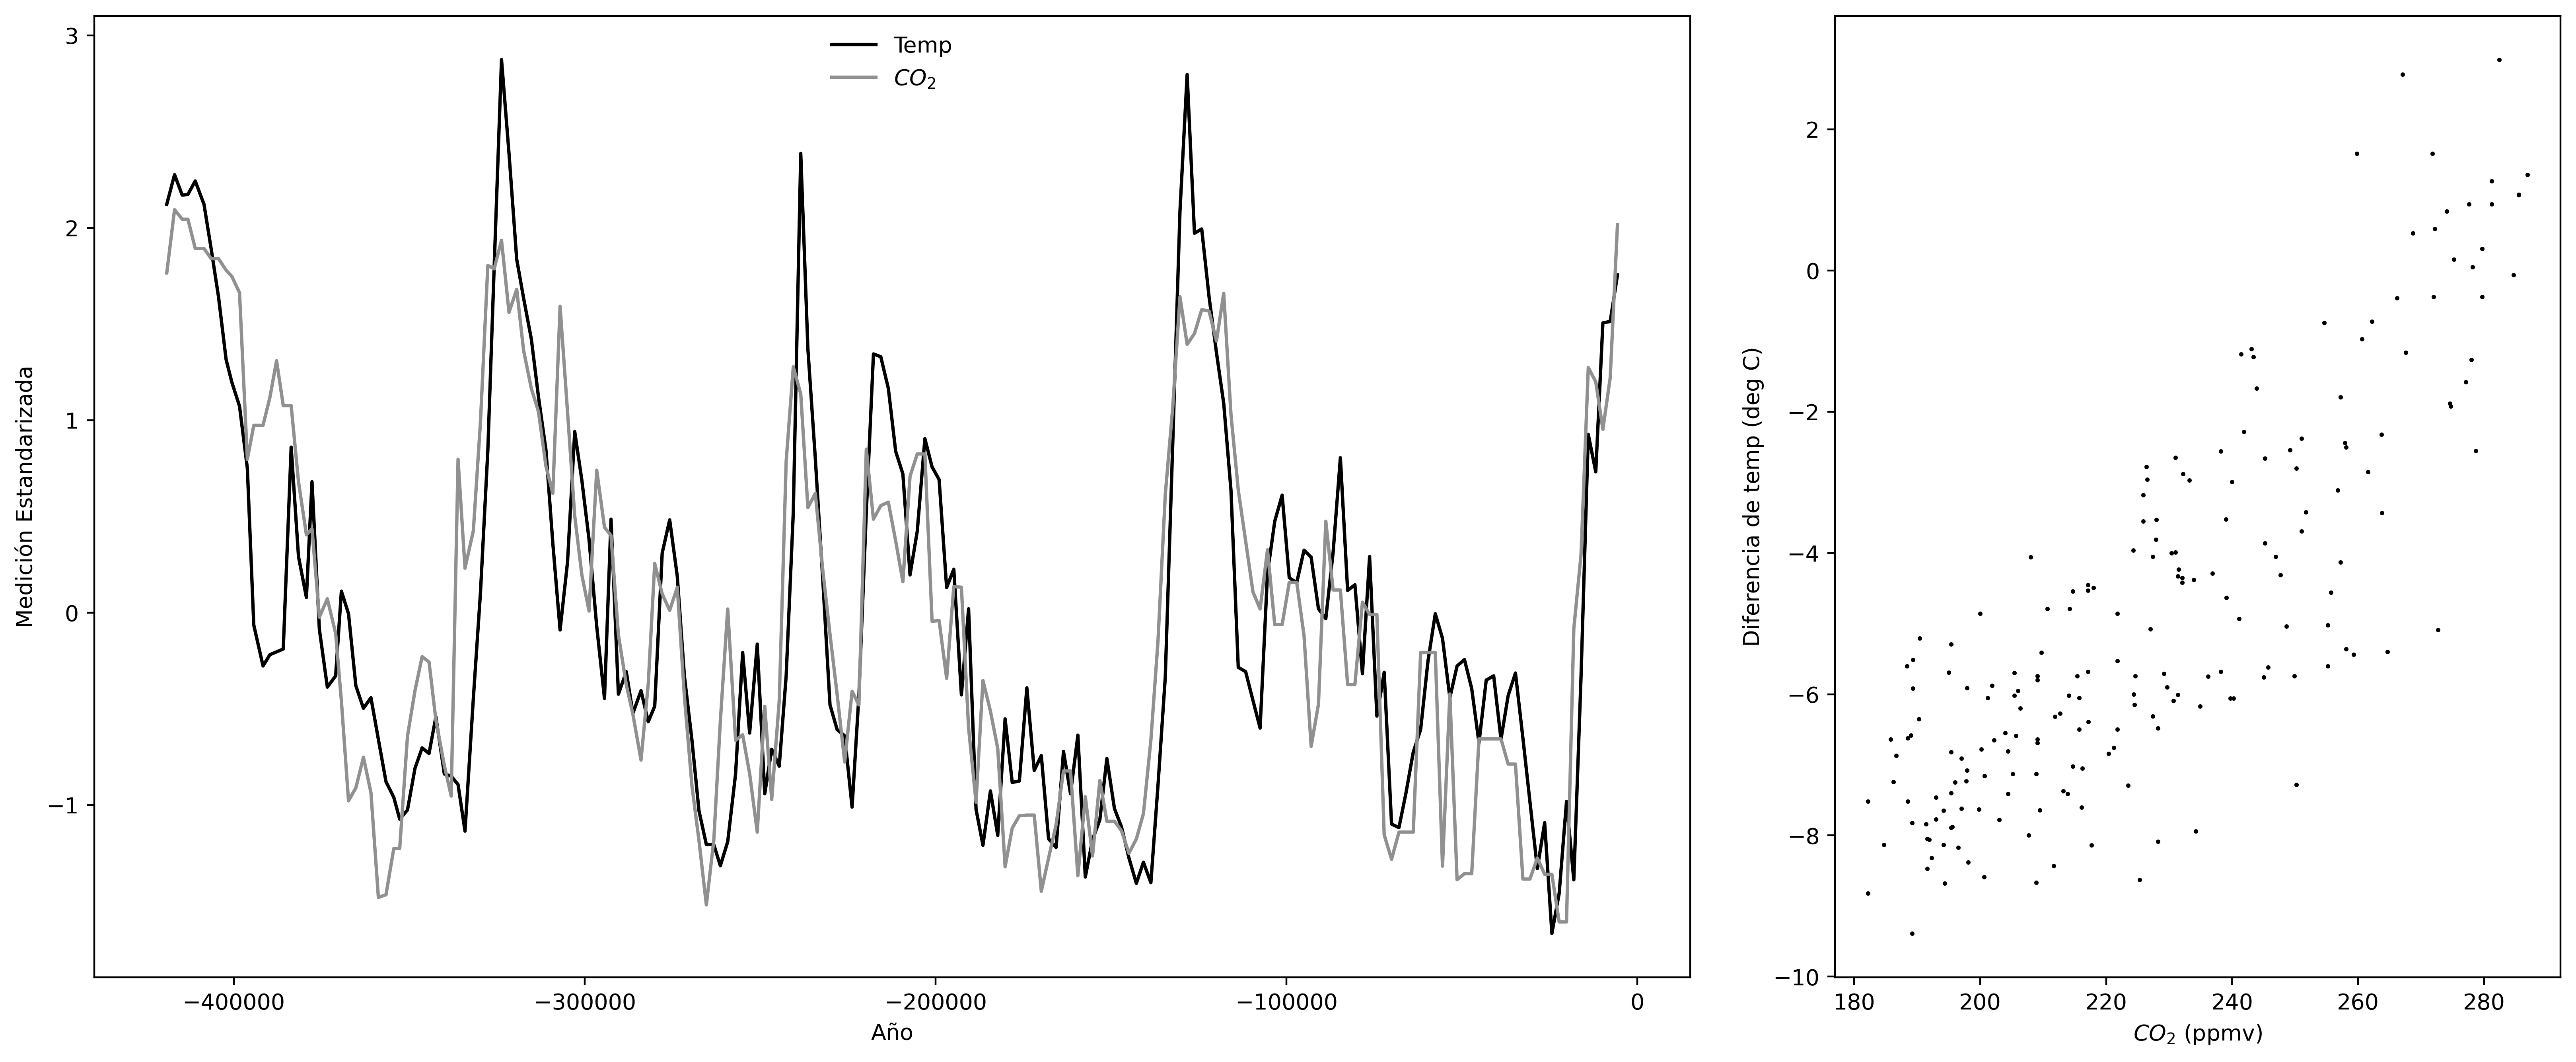

In [3]:
f   = plt.figure(figsize = (20,8), dpi = 400)
ax1 = plt.subplot2grid((1,3),(0,0),colspan = 2,fig = f)
ax2 = plt.subplot2grid((1,3),(0,2),colspan = 1,fig = f)

ax1.plot(dct.year,(dct.tmp-np.mean(dct.tmp))/np.std(dct.tmp),color = 'black',label = 'Temp')
ax1.plot(dct.year,(dct.co2-np.mean(dct.co2))/np.std(dct.co2),color = '#909090',label = r'$CO_2$')
ax1.legend(loc = 9,frameon = False)
ax1.set_xlabel('Año')
ax1.set_ylabel('Medición Estandarizada')

ax2.scatter(dct.co2,dct.tmp,s = 1, c = 'black')
ax2.set_ylabel('Diferencia de temp (deg C)')
ax2.set_xlabel(r'$CO_2$ (ppmv)')

plt.show()

In [4]:
model = sm_f.ols("tmp ~ co2",data = dct).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.685   
Dependent Variable: tmp              AIC:                740.4352
Date:               2022-12-06 15:38 BIC:                747.0318
No. Observations:   200              Log-Likelihood:     -368.22 
Df Model:           1                F-statistic:        433.8   
Df Residuals:       198              Prob (F-statistic): 8.77e-52
R-squared:          0.687            Scale:              2.3498  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     -23.0241   0.8795 -26.1774 0.0000 -24.7586 -21.2897
co2             0.0799   0.0038  20.8290 0.0000   0.0723   0.0874
-----------------------------------------------------------------
Omnibus:               1.012        Durbin-Watson:          0.960
Prob(Omnibus):         0.603        Jarque-Bera (JB):       0.821
Skew:                  -0.154       Prob(JB):               0.663
Kurtosis:              3.061        Condition No.:          1862 
=================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

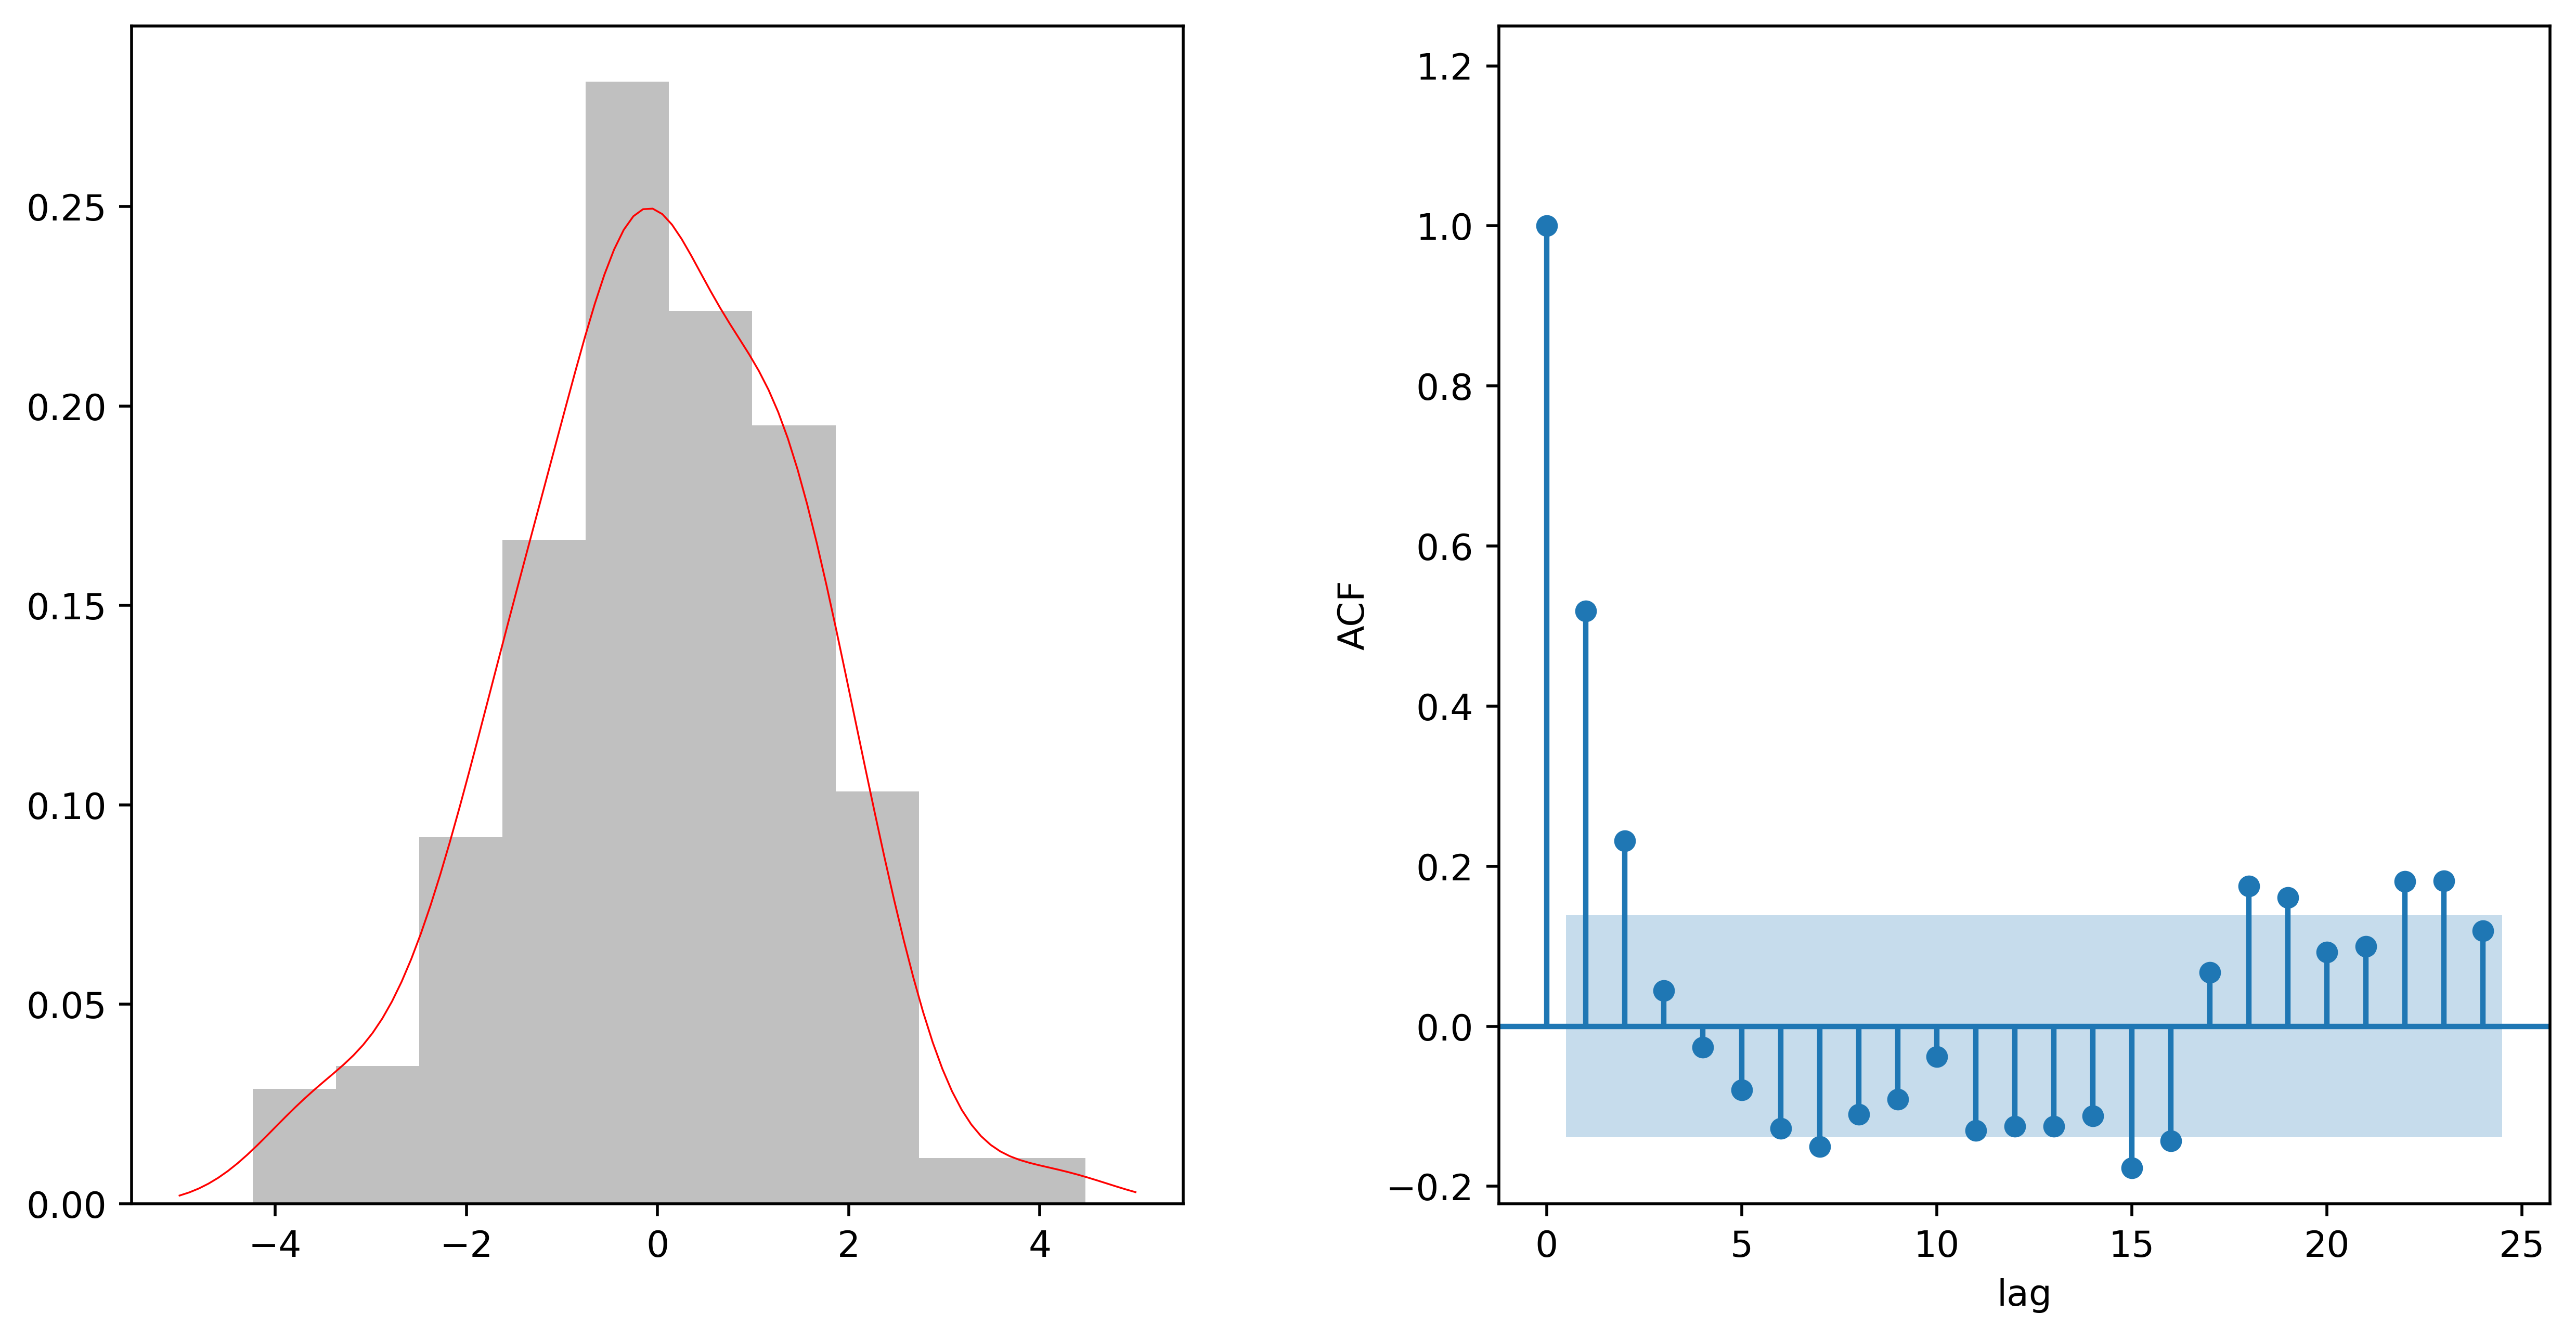

In [5]:
f, ax = plt.subplots(1, 2, figsize = (12,6),dpi = 500)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

ax[0].hist(model.resid,color = '#c0c0c0',density = True)
res_grid = np.linspace(-5,5,num = 100)
ax[0].plot(res_grid,st.gaussian_kde(model.resid)(res_grid),
           color = 'red',
          linewidth = 0.5)

plot_acf(model.resid,ax = ax[1],adjusted = True,
         auto_ylims = True,bartlett_confint = False)
ax[1].set_ylabel('ACF')
ax[1].set_xlabel('lag')
ax[1].set_title('')

plt.show()

In [6]:
########
# MCMC #
########
# data
n       = dct.shape[0]
y       = dct.tmp
X       = np.array(sm.add_constant(np.array(dct.co2)))
tmp_v   = np.arange(1,n+1,1).reshape((n,1))
DY      = np.abs(tmp_v.T - tmp_v)
# valores iniciales
lm_fit  = sm.OLS(y,X).fit()
## Tomado de la guía de la función sm.GLSAR:
fit_gls = sm.GLSAR(y,X,rho = 1)
for i in range(20): # Hallar rho óptimo
    results = fit_gls.fit()
    rho     = sm.regression.yule_walker(results.resid,
                                    order = fit_gls.order)[0]
    fit_gls = sm.GLSAR(y,X,rho)
fit_gls = fit_gls.fit()
##
beta    = np.array(lm_fit.params)
s2      = lm_fit.mse_resid
phi     = acf(lm_fit.resid)[1]
# previa
nu0     = 1
s20     = 1
T0      = np.eye(2)/1000 # SIGMA_0^{-1}

In [7]:
###
np.random.seed(1)
S          = 25000  # número de iteraciones
odens_prog = S/50   # información progreso
odens_save = S/1000 # información almacenar
OUT        = []     # almacenamiento
ac         = 0      # tasa de aceptación
delta      = 0.10   # parámetro de ajuste
# cadena
for s in range(S):
    # simular beta
    Cor    = phi**DY
    iCor   = np.linalg.inv(Cor)
    V_beta = np.linalg.inv( (X.T @ iCor @ X)/s2 + T0 )
    E_beta = V_beta @ (X.T @ iCor @ y)/s2
    beta   = st.multivariate_normal.rvs(mean = E_beta,cov = V_beta)
    # simular sigma^2
    res    = np.array(y- (X @ beta)).reshape((n,1))
    s2     = st.invgamma.rvs((nu0+n)/2,scale = (nu0*s20 + (res.T @ iCor @ res))/2)
    # simular rho (metropolis)
    # 1. propuesta
    phi_p  = np.abs(st.uniform.rvs(loc = phi - delta,scale = 2*delta))
    phi_p  = np.min([phi_p,2-phi_p])
    # 2. tasa de aceptación
    lr     = -0.5*(np.linalg.slogdet(phi_p**DY)[1] - np.linalg.slogdet(phi**DY)[1] +
                    np.trace( res @ res.T @ (np.linalg.inv(phi_p**DY) - np.linalg.inv(phi**DY)))/s2
                  )
    # 3. actualizar el valor
    if np.log(st.uniform.rvs()) < lr:
        phi = phi_p
        ac += 1
    # progreso
    if (s+1)%odens_prog == 0:
        print(s+1,np.round(ac/s,2),np.round(beta,3),np.round(s2,3),np.round(phi,3))
    # almacenar
    if (s+1)%odens_save == 0:
        OUT.append(list(beta)+[s2,phi])
        
# guardar muestras
OUT = np.array(OUT)
np.save("OUT25000.npy",OUT)

500 0.3 [-10.907   0.025] 3.645 0.812
1000 0.32 [-7.668  0.018] 7.155 0.881
1500 0.32 [-6.605  0.013] 6.867 0.874
2000 0.3 [-10.256   0.023] 4.504 0.775
2500 0.3 [-10.834   0.029] 5.507 0.856
3000 0.3 [-15.16    0.046] 3.483 0.753
3500 0.29 [-9.214  0.022] 5.829 0.861
4000 0.29 [-7.163e+00  7.000e-03] 7.336 0.893
4500 0.28 [-11.498   0.032] 4.721 0.788
5000 0.28 [-11.024   0.029] 4.717 0.822
5500 0.28 [-11.631   0.029] 4.005 0.811
6000 0.28 [-11.285   0.028] 3.29 0.795
6500 0.28 [-10.591   0.022] 9.354 0.901
7000 0.29 [-9.174  0.018] 8.244 0.911
7500 0.29 [-12.528   0.036] 4.66 0.81
8000 0.28 [-8.634  0.019] 6.152 0.869
8500 0.28 [-9.897  0.023] 6.572 0.878
9000 0.28 [-10.239   0.028] 4.407 0.84
9500 0.28 [-10.266   0.022] 5.693 0.863
10000 0.28 [-10.194   0.026] 4.24 0.771
10500 0.27 [-12.299   0.031] 3.85 0.754
11000 0.27 [-8.685  0.021] 7.578 0.889
11500 0.27 [-12.815   0.032] 5.37 0.858
12000 0.27 [-10.076   0.027] 7.547 0.893
12500 0.27 [-8.88   0.019] 5.301 0.833
13000 0.27 [-8.3

In [8]:
################
# diagnósticos #
################
# cargar la cadena 25000
OUT = np.load("OUT25000.npy")
[av.ess(OUT[:,k],method = 'mean') for k in range(4)]

[672.567019994915, 681.3773559406812, 379.01518927789004, 424.89463214745797]

In [9]:
np.mean(OUT[100:,1])

0.026954068482469316

In [10]:
np.quantile(OUT[:,1],q = [0.025,0.5,0.975])

array([0.01060474, 0.02663599, 0.04642058])

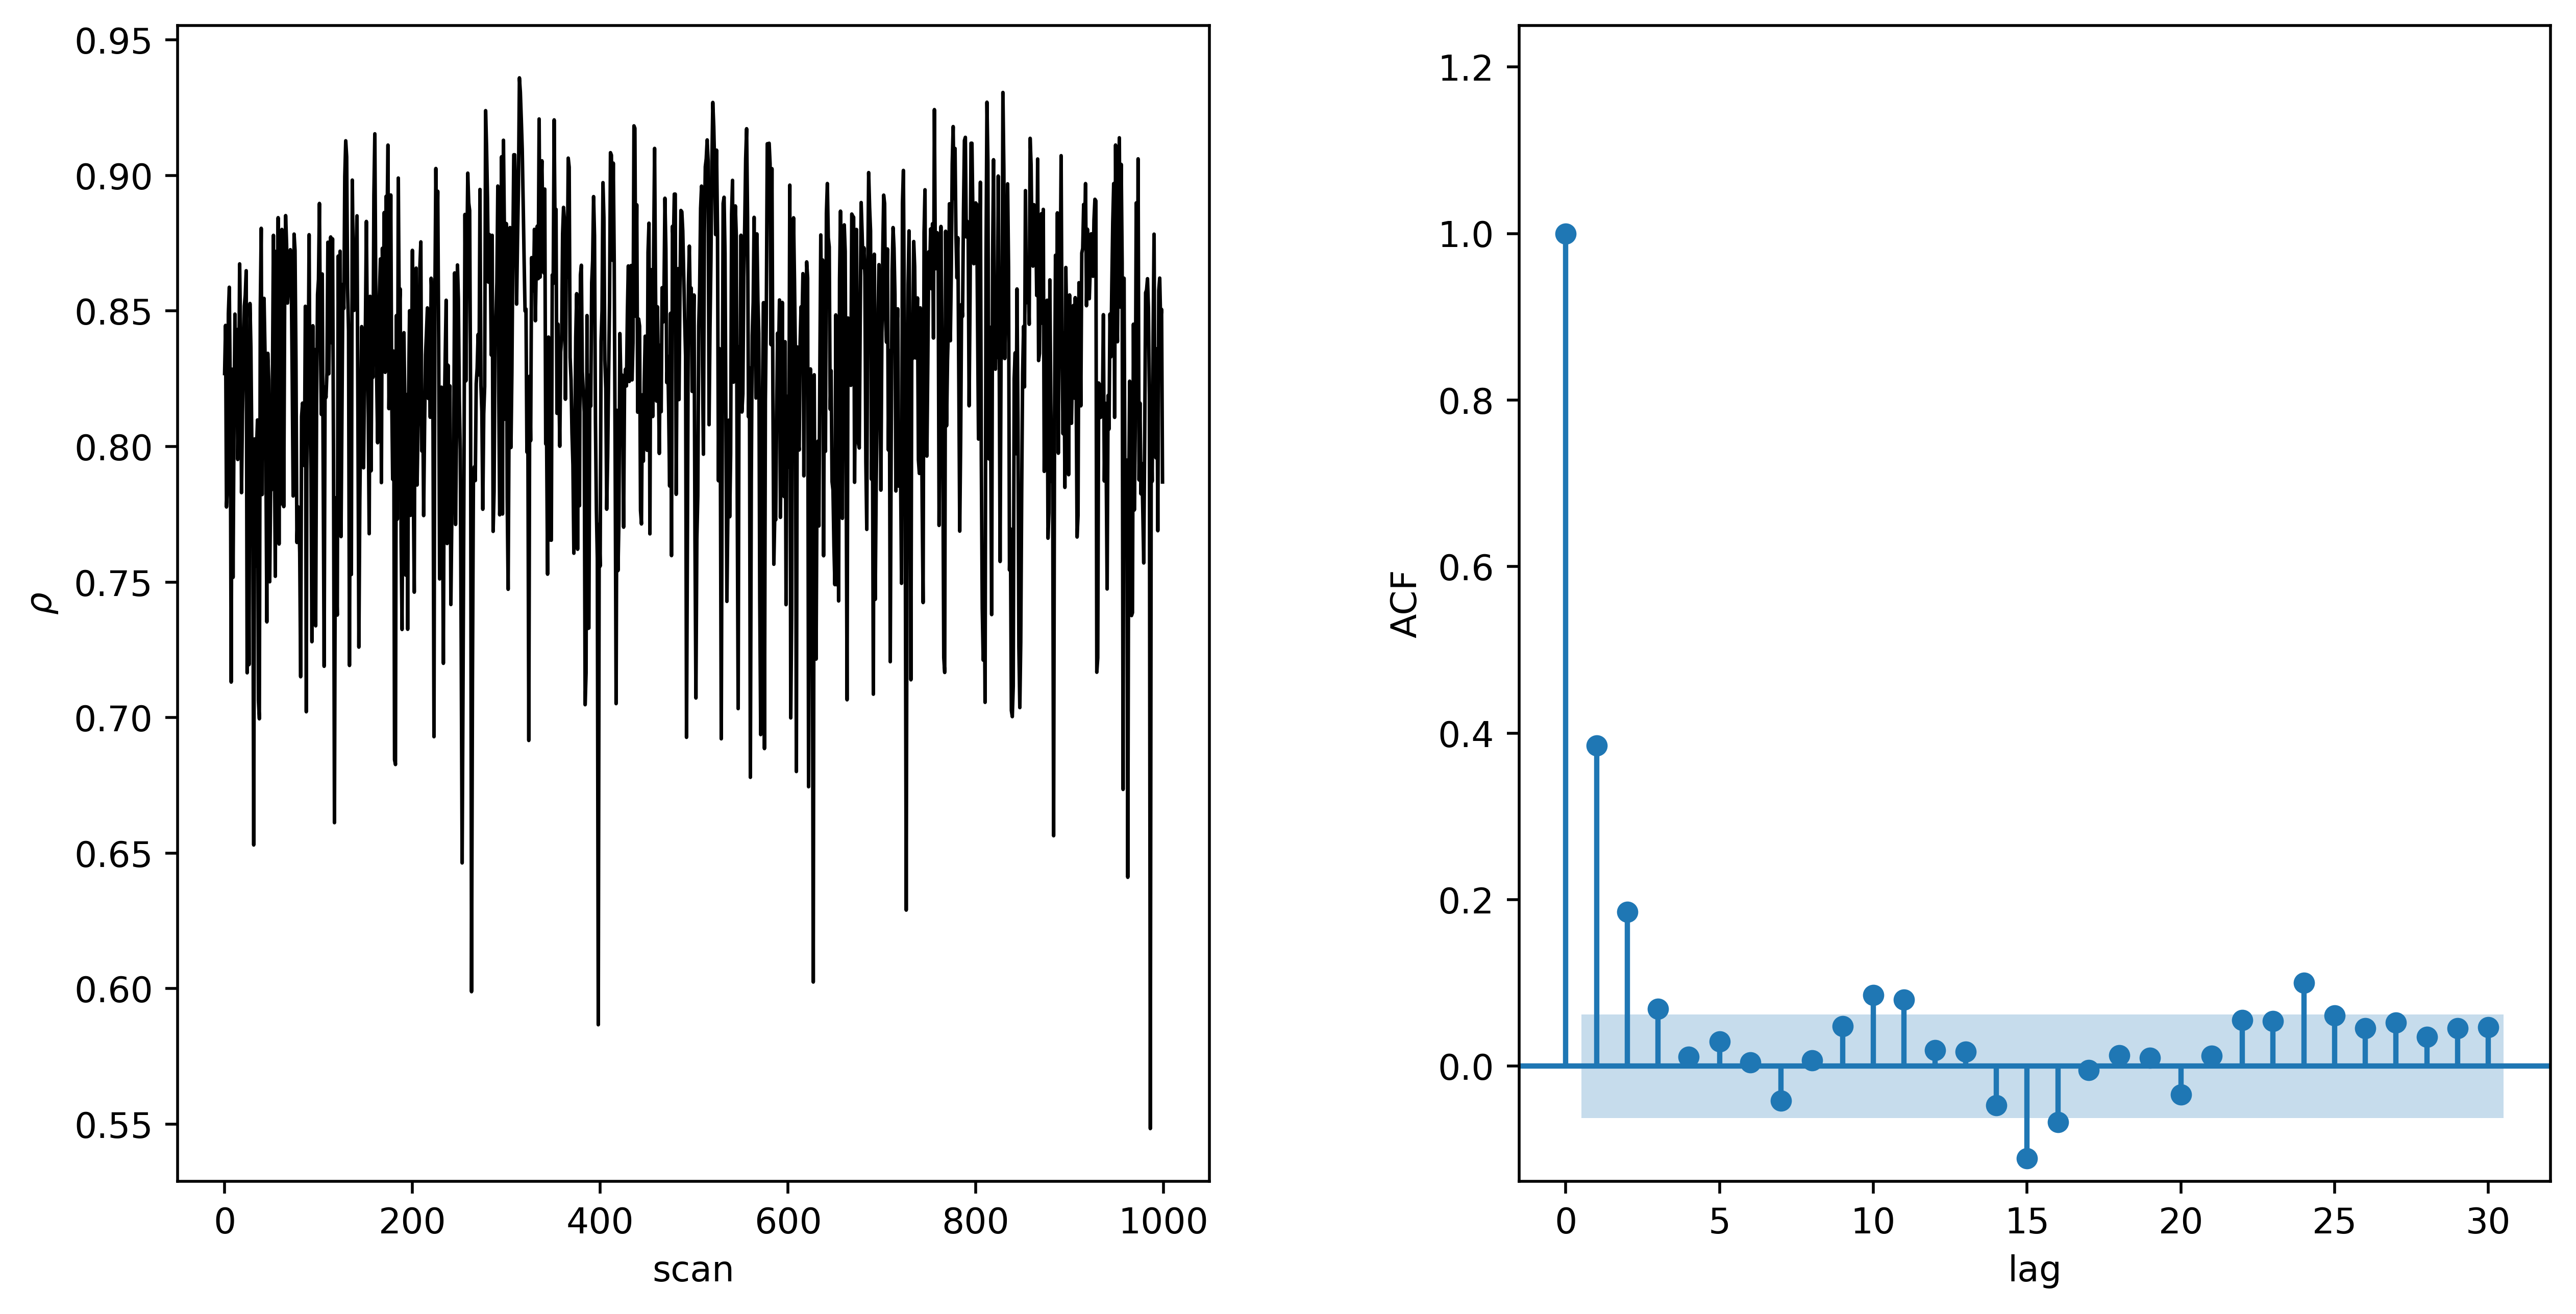

In [11]:
f, ax = plt.subplots(1, 2, figsize = (12,6),dpi = 500)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

ax[0].plot(OUT[:,3],color = 'black',linewidth = 1)
ax[0].set_ylabel(r'$\rho$')
ax[0].set_xlabel('scan')

plot_acf(OUT[:,3],ax = ax[1],adjusted = True,
         auto_ylims = True,bartlett_confint = False)
ax[1].set_ylabel('ACF')
ax[1].set_xlabel('lag')
ax[1].set_title('')

plt.show()

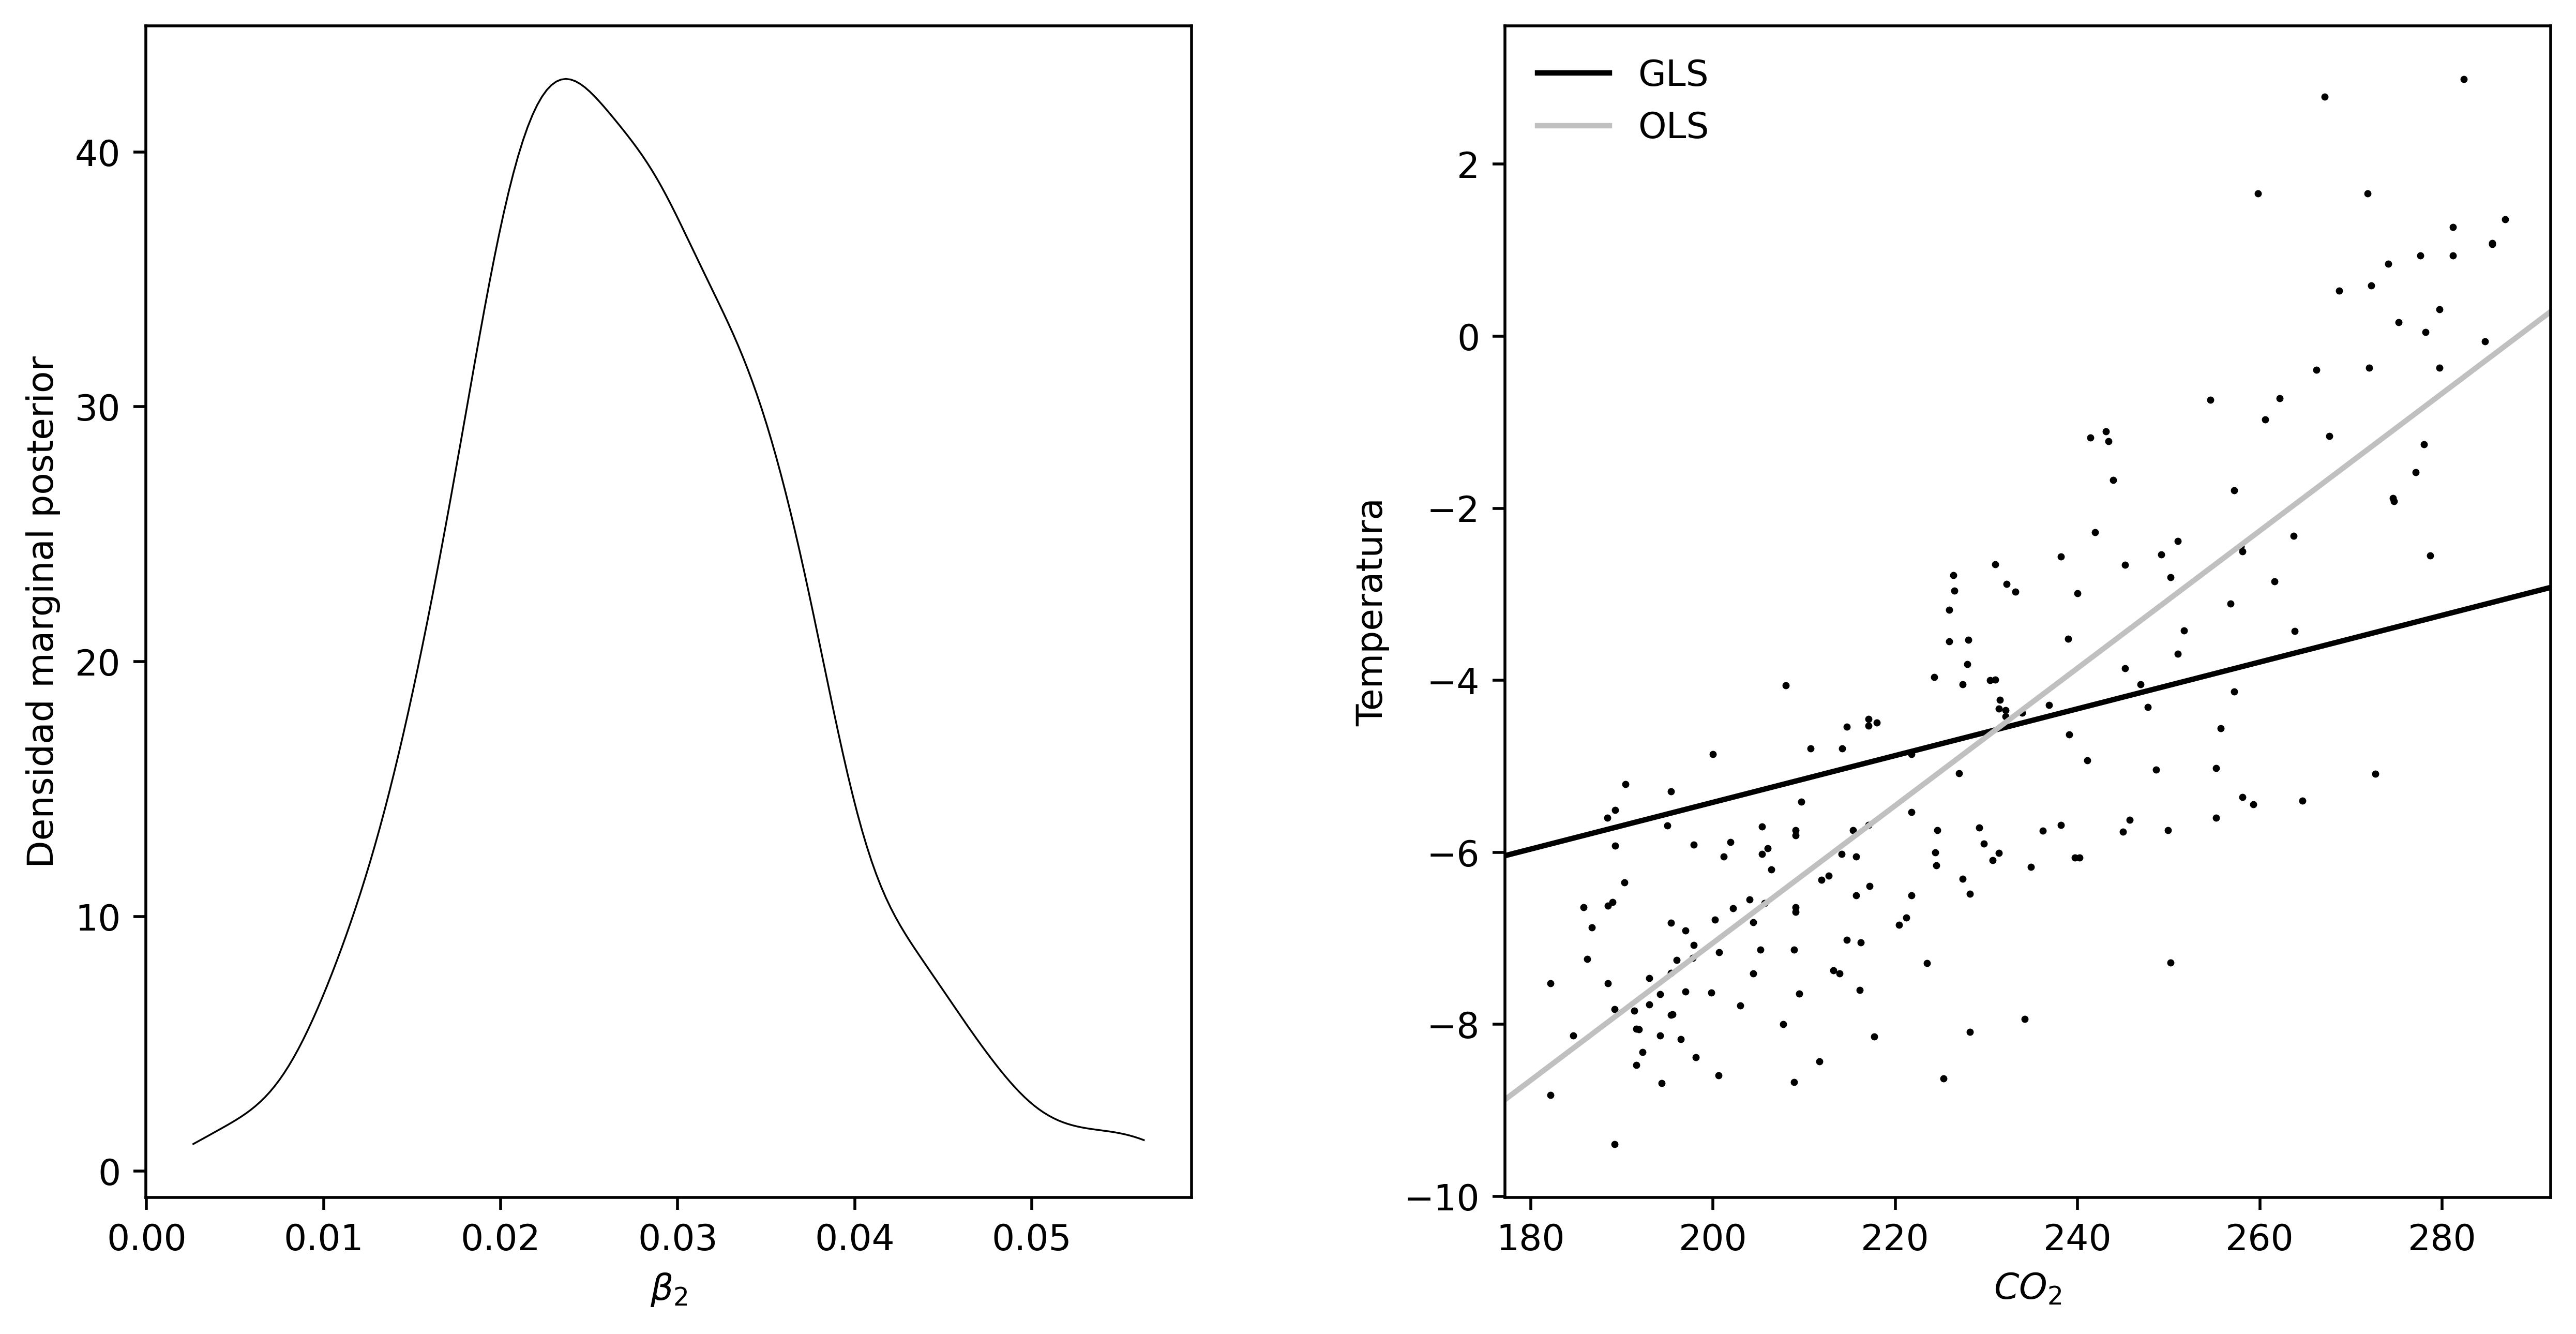

In [12]:
##############
# Inferencia #
##############
f, ax = plt.subplots(1, 2, figsize = (12,6),dpi = 500)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

x_grid = np.linspace(np.min(OUT[:,1]),np.max(OUT[:,1]),num = 200)
ax[0].plot(x_grid, st.gaussian_kde(OUT[:,1])(x_grid),
           color = 'black',linewidth = 0.5)
ax[0].set_xlabel(r'$\beta_2$')
ax[0].set_ylabel('Densidad marginal posterior')

x_grid = np.linspace(np.min(X[:,1])-5,np.max(X[:,1])+5,num = 200)
ax[1].scatter(X[:,1],y,c = 'black',s = 1)
ax[1].plot(x_grid,np.mean(OUT[:,0]) + x_grid * np.mean(OUT[:,1]),
           color = 'black',label = 'GLS')
ax[1].plot(x_grid,lm_fit.params[0] + x_grid * lm_fit.params[1],
          color = '#c0c0c0',label = 'OLS')
ax[1].set_xlabel(r'$CO_2$')
ax[1].set_ylabel('Temperatura')
ax[1].set_xlim((np.min(X[:,1])-5,np.max(X[:,1])+5))
ax[1].legend(loc = 2,frameon = False)


plt.show()

In [13]:
########
# JAGS #
########

# data
dct     = pd.read_csv("dct.csv")
y       = dct.tmp
X       = np.array(sm.add_constant(dct.co2))
n, p    = X.shape
tmp_v   = np.arange(1,n+1,1).reshape((n,1))
DY      = np.abs(tmp_v.T - tmp_v) # para construir la matriz de correlacion

code = '''
    model {
        y[1:n] ~ dmnorm(X[1:n,1:p]%*%beta[1:p], phi*inverse(ilogit(rho)^DY[1:n,1:n]))
        beta[1:p] ~ dmnorm(beta0[1:p], Omega0[1:p,1:p])
        phi ~ dgamma(a0, b0)
        rho ~ dnorm(c0, d0)
        log_like = logdensity.mnorm(y[1:n],X[1:n,1:p]%*%beta[1:p],phi*inverse(ilogit(rho)^DY[1:n,1:n]))
    }
'''

# previa
beta0   = np.zeros(p)
Omega0  = np.eye(p)/1000
a0      = 1/2
b0      = 1/2
c0      = 0
d0      = 1/1000

# input
model_data = dict({
    'y'      : y,
    'X'      : X,
    'DY'     : DY,
    'n'      : n,
    'p'      : p,
    'beta0'  : beta0,
    'Omega0' : Omega0,
    'a0'     : a0,
    'b0'     : b0,
    'c0'     : c0,
    'd0'     : d0
})

# parameters
model_parameters = ['beta','phi','rho','log_like']

# initial values
initial_values = [
    dict({
        'beta' : np.mean(OUT[:,:2],axis = 0),
        'phi'  : 1/np.mean(OUT[:,2]),
        'rho'  : np.log(np.mean(OUT[:,3])/(1-np.mean(OUT[:,3])))
    })
]*3

# mcmc settings
niter  = 1100
nburn  = 100
nthin  = 1
nchain = len(initial_values)

# mcmc
np.random.seed(123)
model = pj.Model(code, data = model_data, chains = nchain,init = initial_values,progress_bar = True)
fit   = model.sample(iterations = nburn + niter, vars = model_parameters,thin = nthin)

adapting: iterations 69 of 3000, elapsed 0:00:09, remaining 0:06:31
adapting: iterations 141 of 3000, elapsed 0:00:18, remaining 0:06:12
adapting: iterations 177 of 3000, elapsed 0:00:24, remaining 0:06:18
adapting: iterations 213 of 3000, elapsed 0:00:29, remaining 0:06:17
adapting: iterations 249 of 3000, elapsed 0:00:34, remaining 0:06:18
adapting: iterations 285 of 3000, elapsed 0:00:40, remaining 0:06:17
adapting: iterations 321 of 3000, elapsed 0:00:45, remaining 0:06:13
adapting: iterations 354 of 3000, elapsed 0:00:53, remaining 0:06:38
adapting: iterations 387 of 3000, elapsed 0:01:00, remaining 0:06:48
adapting: iterations 447 of 3000, elapsed 0:01:10, remaining 0:06:41
adapting: iterations 477 of 3000, elapsed 0:01:16, remaining 0:06:41
adapting: iterations 507 of 3000, elapsed 0:01:25, remaining 0:06:56
adapting: iterations 534 of 3000, elapsed 0:01:31, remaining 0:07:01
adapting: iterations 588 of 3000, elapsed 0:01:40, remaining 0:06:49
adapting: iterations 642 of 3000, e

sampling: iterations 2844 of 3600, elapsed 0:07:50, remaining 0:02:05
sampling: iterations 2874 of 3600, elapsed 0:07:56, remaining 0:02:00
sampling: iterations 2904 of 3600, elapsed 0:08:01, remaining 0:01:55
sampling: iterations 2964 of 3600, elapsed 0:08:10, remaining 0:01:45
sampling: iterations 3024 of 3600, elapsed 0:08:19, remaining 0:01:35
sampling: iterations 3084 of 3600, elapsed 0:08:28, remaining 0:01:25
sampling: iterations 3144 of 3600, elapsed 0:08:38, remaining 0:01:15
sampling: iterations 3174 of 3600, elapsed 0:08:43, remaining 0:01:10
sampling: iterations 3234 of 3600, elapsed 0:08:52, remaining 0:01:00
sampling: iterations 3264 of 3600, elapsed 0:08:57, remaining 0:00:55
sampling: iterations 3294 of 3600, elapsed 0:09:02, remaining 0:00:50
sampling: iterations 3354 of 3600, elapsed 0:09:12, remaining 0:00:40
sampling: iterations 3414 of 3600, elapsed 0:09:20, remaining 0:00:31
sampling: iterations 3474 of 3600, elapsed 0:09:30, remaining 0:00:21
sampling: iterations

In [14]:
# convertir a objeto del paquete arviz (av)
fit_mcmc = av.from_pyjags(
    posterior = fit, 
    log_likelihood = {'y': 'log_like'}, 
    save_warmup = True, 
    warmup_iterations = nburn
)
fit_mcmc

Inference data with groups:
	> posterior
	> log_likelihood

Warmup iterations saved (warmup_*).

In [15]:
av.summary(fit_mcmc,hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-10.196,2.343,-14.776,-5.613,0.201,0.142,138.0,654.0,1.03
beta[1],0.025,0.009,0.007,0.042,0.001,0.000,164.0,568.0,1.03
phi,0.174,0.064,0.047,0.286,0.013,0.009,23.0,86.0,1.10
rho,1.856,0.480,0.988,2.825,0.099,0.071,24.0,92.0,1.10


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>]], dtype=object)

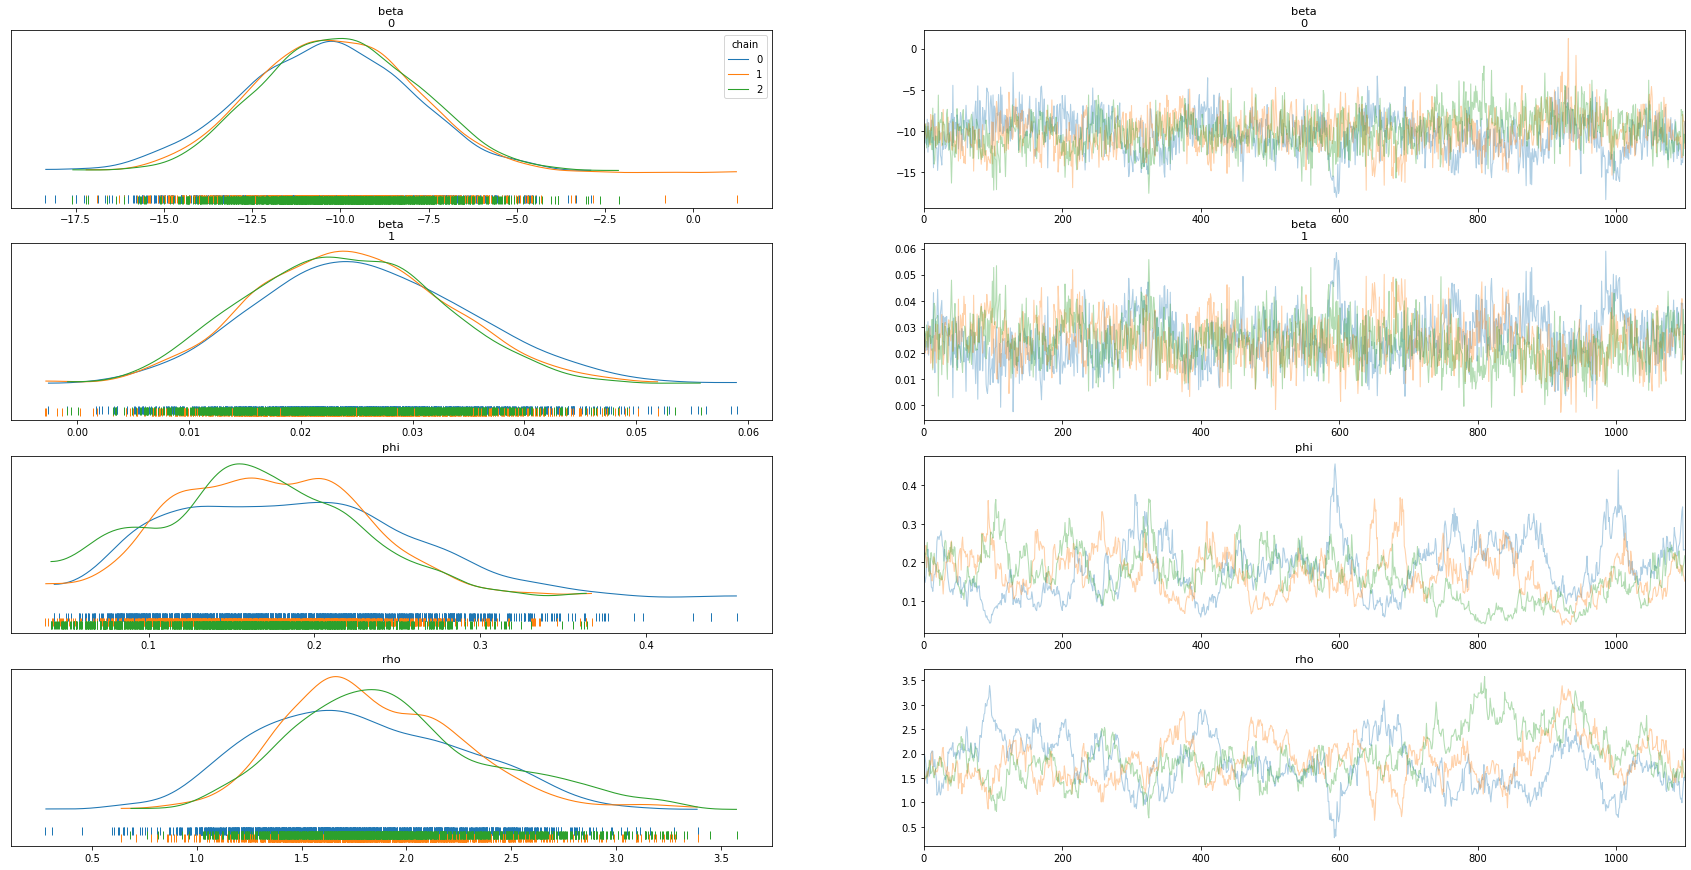

In [16]:
av.plot_trace(fit_mcmc, compact = False, legend = True, figsize = (30,15), rug = True)

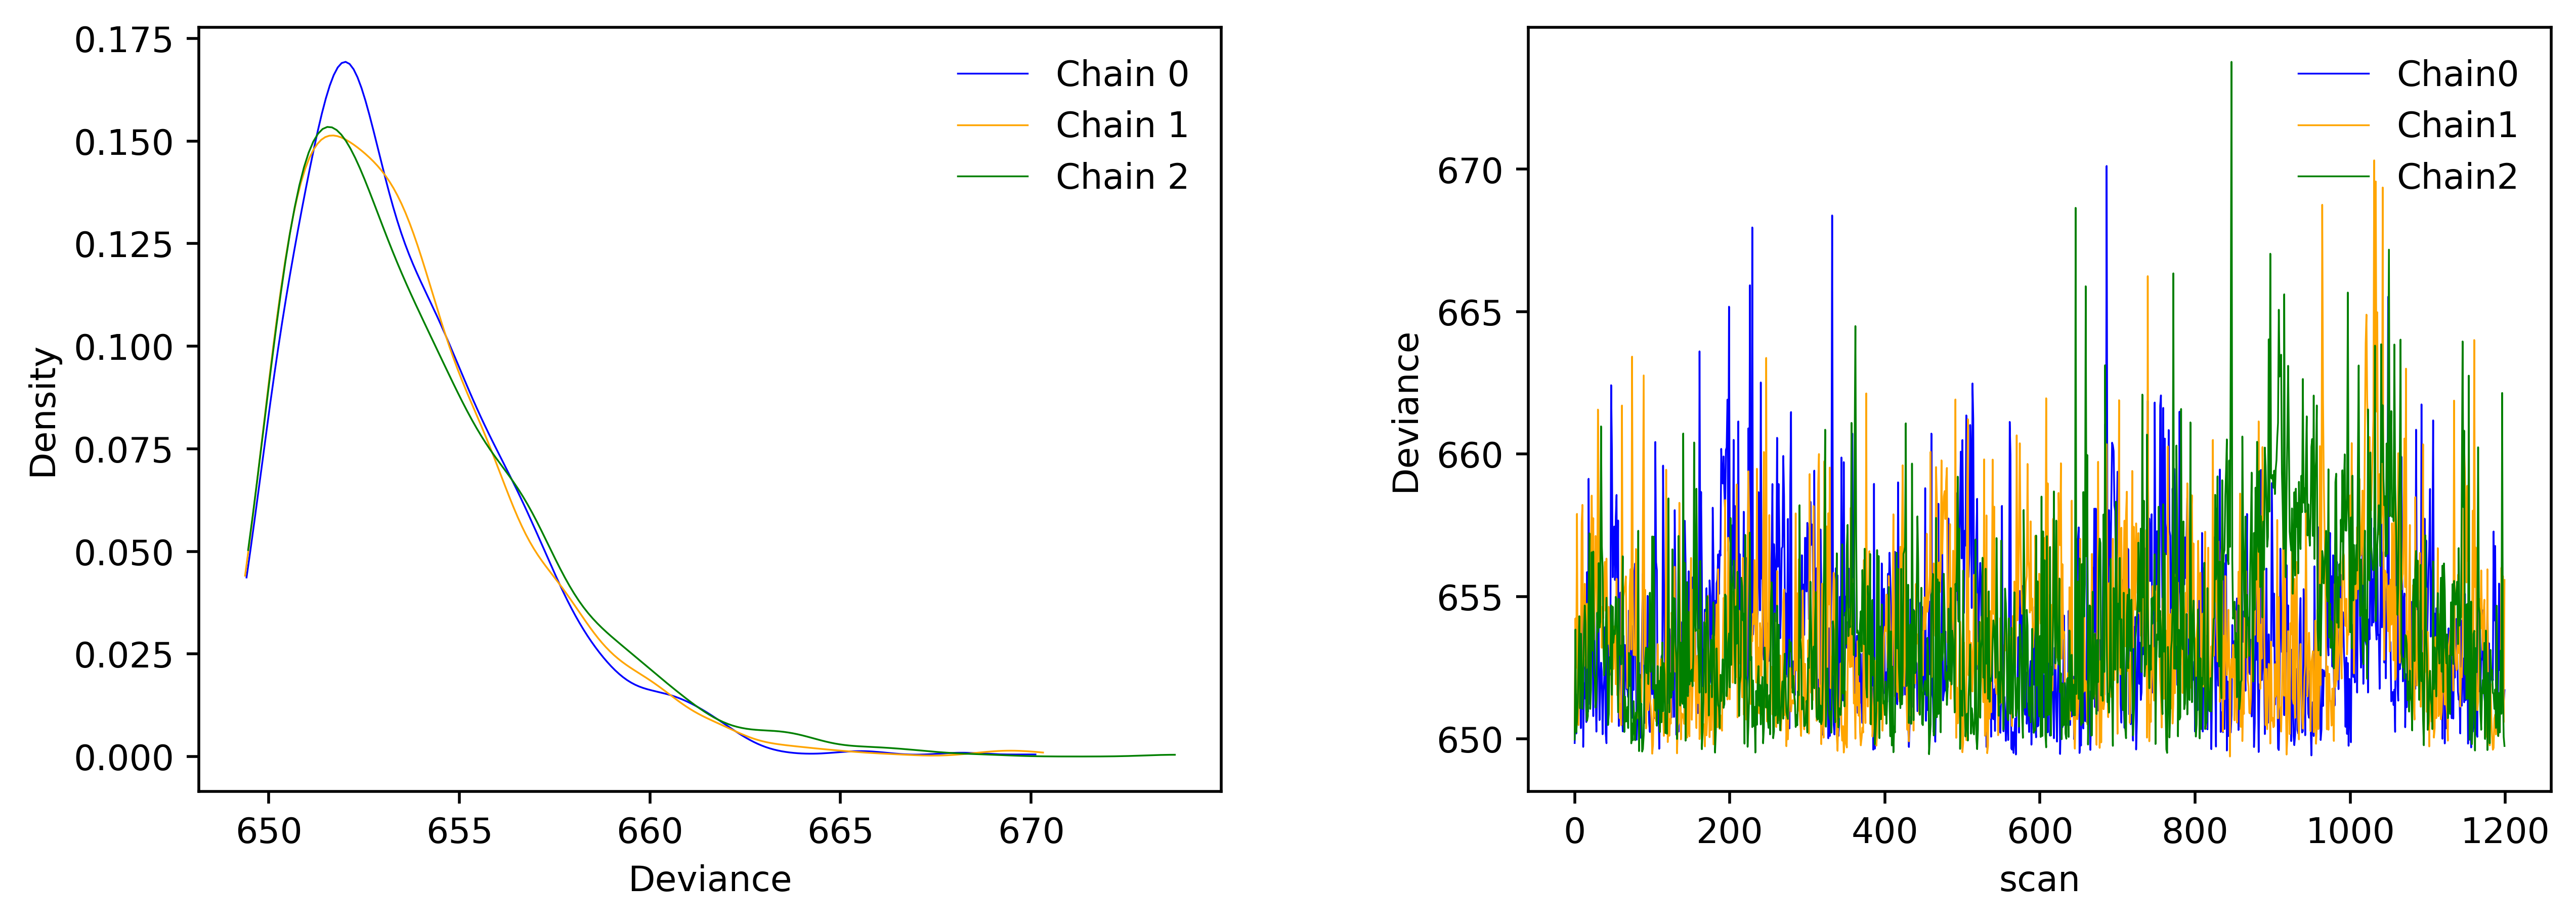

In [17]:
f, ax = plt.subplots(1, 2, figsize = (12,4),dpi = 500)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
colors = np.array(['blue','orange','green'])

for i in range(3):
    dev = -2*fit['log_like'][0,:,i]
    dev_grid = np.linspace(np.min(dev),np.max(dev),num = 200)
    ax[0].plot(dev_grid,st.gaussian_kde(dev)(dev_grid),
              linewidth = 0.5,color = colors[i],label = 'Chain ' + str(i))
    ax[1].plot(dev,linewidth = 0.5, color = colors[i],label = 'Chain' + str(i))

ax[0].set_xlabel('Deviance')
ax[0].set_ylabel('Density')
ax[1].set_xlabel('scan')
ax[1].set_ylabel('Deviance')
ax[0].legend(loc = 1,frameon = False)
ax[1].legend(loc = 1,frameon = False)
plt.show()